# A Study on Gradient Boosting Algorithms and Hyperparameter Optimization using Optuna

Undergraduate Thesis submitted to the Undergraduate Course in Mechatronics Engineering from São Carlos School of Engineering, University of São Paulo – EESC- USP, in partial fulfillment of the requirements for the bachelor degree in Mechatronics Engineer .

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sys
import timeit
import gc
import sklearn
import seaborn
from sklearn import metrics
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import optuna
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
import shap
import validation_train
from validation_train import auc_logloss_ks
from validation_train import objective
from validation_train import tuning
from validation_train import train
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from sklearn import preprocessing
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

# 2.0 - Heart Failure Dataset
[Heart Failure Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

In [2]:
df_heart = pd.read_csv('02_heart_dataset.csv')
df_heart

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.200,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.400,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.200,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.000,Flat,1


In [4]:
# get columns name
df_heart.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [5]:
# columns type
df_heart.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [6]:
# check for null
df_heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [7]:
df_heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000,918.000,918.000,918.000,918.000,918.000,918.000
mean,53.511,132.397,198.800,0.233,136.809,0.887,0.553
std,9.433,18.514,109.384,0.423,25.460,1.067,0.497
min,28.000,0.000,0.000,0.000,60.000,-2.600,0.000
25%,47.000,120.000,173.250,0.000,120.000,0.000,0.000
50%,54.000,130.000,223.000,0.000,138.000,0.600,1.000
75%,60.000,140.000,267.000,0.000,156.000,1.500,1.000
max,77.000,200.000,603.000,1.000,202.000,6.200,1.000


In [8]:
df_heart.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

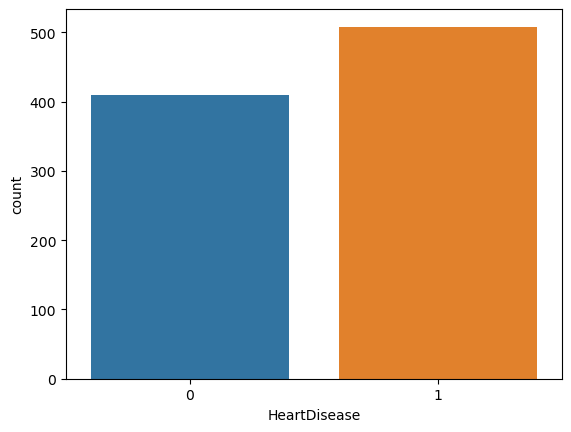

In [9]:
seaborn.countplot(x = 'HeartDisease',data = df_heart)
plt.savefig('heart_tot.png')

In [10]:
df_heart[['Sex']].value_counts()

Sex
M      725
F      193
dtype: int64

In [11]:
df_heart['ChestPainType'].value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [12]:
df_heart['RestingECG'].value_counts()

Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64

In [13]:
df_heart['ExerciseAngina'].value_counts()

N    547
Y    371
Name: ExerciseAngina, dtype: int64

In [14]:
df_heart['ST_Slope'].value_counts()

Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64

In [3]:
cols_cat_heart = ['Sex', 'ChestPainType','RestingECG','ExerciseAngina','ST_Slope']

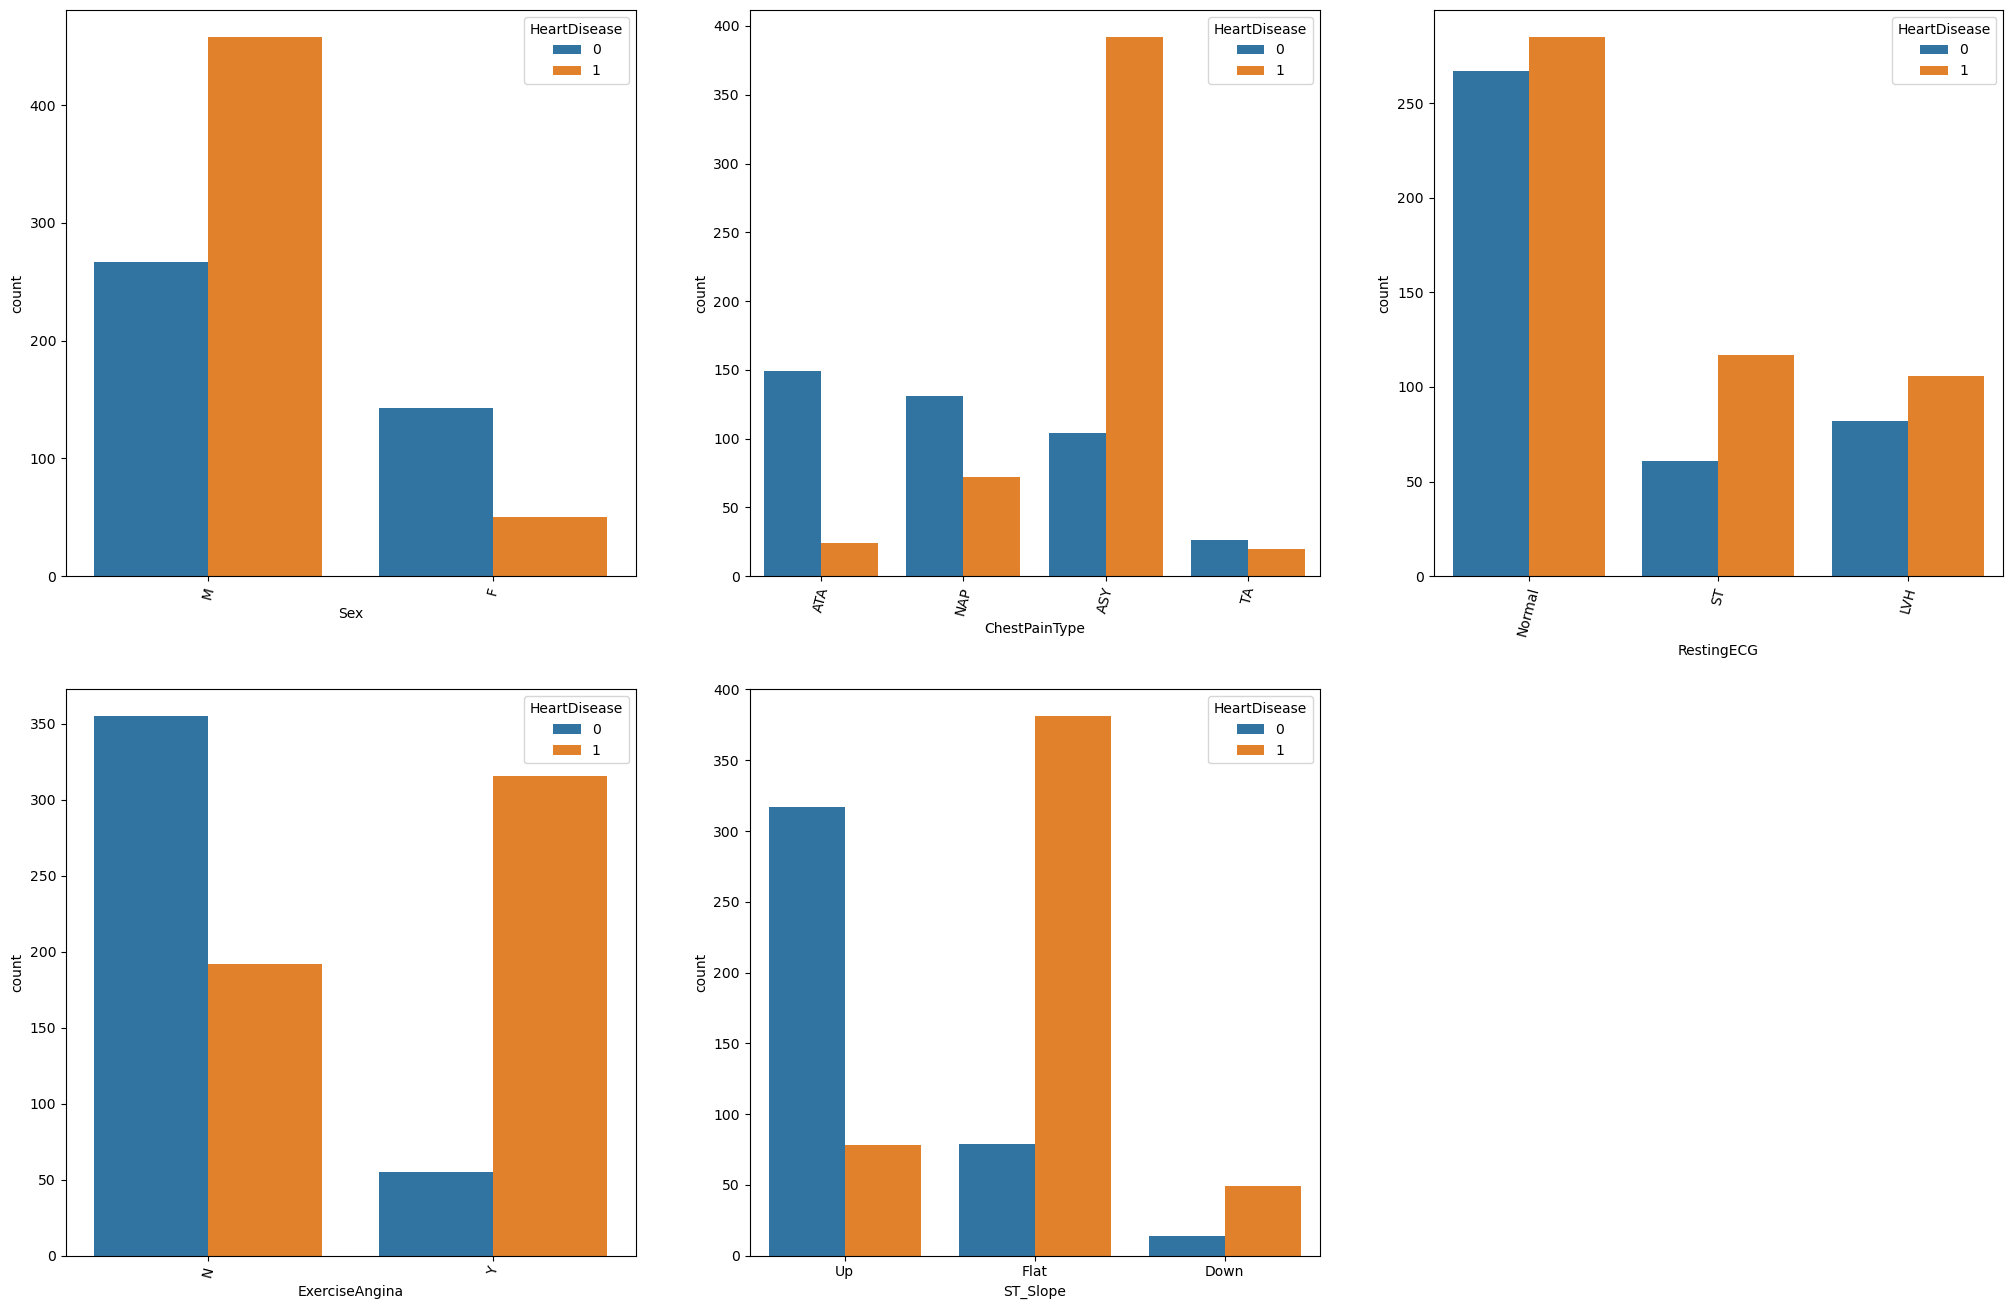

In [16]:

plt.figure(figsize = (25,25))

i  = 0
for j in range(5):
    plt.xticks(rotation=75)
    plt.subplot(int(str(3)+str(3)+str(j+1)))
    seaborn.countplot(x = cols_cat_heart[i], hue='HeartDisease',data = df_heart)
    i += 1

plt.savefig('heart_cat.png')

<Figure size 2500x2500 with 0 Axes>

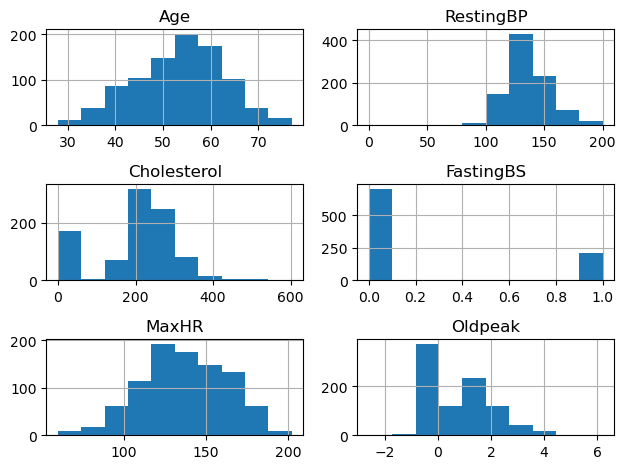

In [17]:
plt.figure(figsize = (25,25))
df_heart[['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak']].hist()
plt.tight_layout()
plt.savefig('hist_heart_t.png')

<Figure size 2500x2500 with 0 Axes>

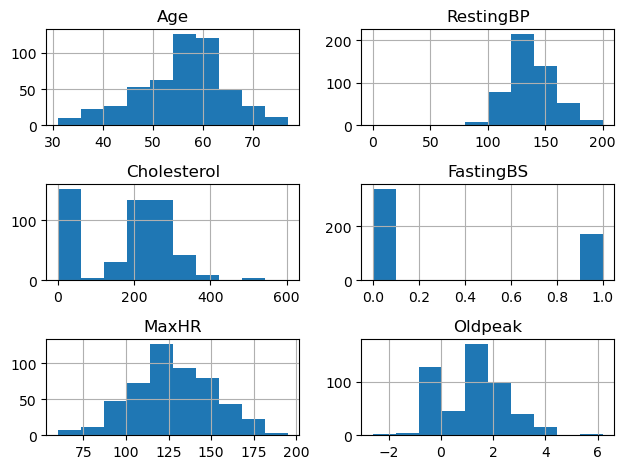

In [18]:
plt.figure(figsize = (25,25))
df_heart[['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak']].loc[df_heart['HeartDisease']==1].hist()
plt.tight_layout()
plt.savefig('hist_heart_yes.png')

<Figure size 2500x2500 with 0 Axes>

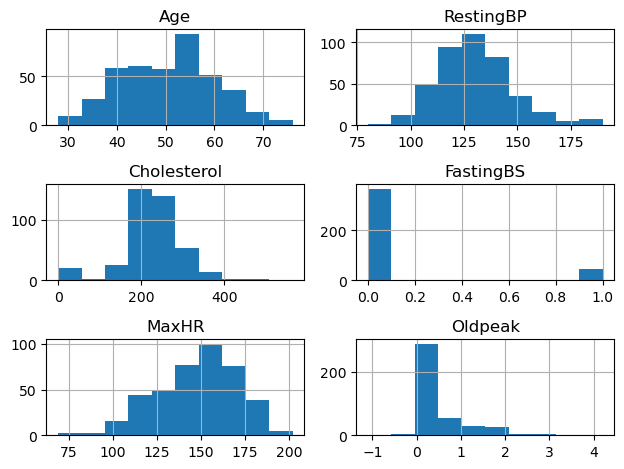

In [19]:
plt.figure(figsize = (25,25))
df_heart[['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak']].loc[df_heart['HeartDisease']==0].hist()
plt.tight_layout()
plt.savefig('hist_heart_no.png')

In [4]:
df_heart_conv = df_heart.copy()

In [5]:
label_encoder = preprocessing.LabelEncoder()
df_heart_conv['Sex'] = label_encoder.fit_transform(df_heart_conv['Sex'])
df_heart_conv['RestingECG'] = label_encoder.fit_transform(df_heart_conv['RestingECG'])
df_heart_conv['ChestPainType'] = label_encoder.fit_transform(df_heart_conv['ChestPainType'])
df_heart_conv['ExerciseAngina'] = label_encoder.fit_transform(df_heart_conv['ExerciseAngina'])
df_heart_conv['ST_Slope'] = label_encoder.fit_transform(df_heart_conv['ST_Slope'])

In [6]:
df_heart_conv

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.000,2,0
1,49,0,2,160,180,0,1,156,0,1.000,1,1
2,37,1,1,130,283,0,2,98,0,0.000,2,0
3,48,0,0,138,214,0,1,108,1,1.500,1,1
4,54,1,2,150,195,0,1,122,0,0.000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.200,1,1
914,68,1,0,144,193,1,1,141,0,3.400,1,1
915,57,1,0,130,131,0,1,115,1,1.200,1,1
916,57,0,1,130,236,0,0,174,0,0.000,1,1


In [29]:
df_heart_conv.dtypes

Age                 int64
Sex                 int64
ChestPainType       int64
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG          int64
MaxHR               int64
ExerciseAngina      int64
Oldpeak           float64
ST_Slope            int64
HeartDisease        int64
dtype: object

## XGBoost

In [7]:
var_cols = df_heart_conv.drop(columns='HeartDisease').columns

In [8]:
var_cols

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')

In [9]:
X = df_heart_conv.loc[:,var_cols]
y = df_heart_conv.loc[:,'HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((642, 11), (276, 11), (642,), (276,))

In [127]:
parameters = {
        'learning_rate': 0.3,
        'max_depth': 3,
        'lambda': 0.05
}

In [128]:
XGBoost_class = XGBClassifier(**parameters)

In [129]:
start = timeit.default_timer()
XGBoost_model = XGBoost_class.fit(X_train, y_train)
stop = timeit.default_timer()
stop - start

0.09487192600136041

In [130]:
y_prob = XGBoost_model.predict(X_test)
auc_logloss_ks(y_test, y_prob)

(0.8535496515679443, 5.255938417945077, 0.7070993031358884)

### XGBoost using optuna

In [54]:
XGBoost_model, study_xgb = train(X_train, y_train, X_test, y_test, balanced='balanced', method='XGBoost')

In [53]:
# optuna.visualization.plot_optimization_history(study_xgb)

In [44]:
# optuna.visualization.plot_param_importances(study_xgb)

In [49]:
# optuna.visualization.plot_slice(study_xgb, ['min_child_weight'])

In [50]:
# optuna.visualization.plot_slice(study_xgb, ['learning_rate'])

In [51]:
# optuna.visualization.plot_slice(study_xgb, ['max_depth'])

In [52]:
# optuna.visualization.plot_slice(study_xgb, ['lambda'])

## CatBoost

In [33]:
df_heart.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [10]:
col_cat = df_heart.drop(columns='HeartDisease').columns

In [11]:
X = df_heart.loc[:,col_cat]
y = df_heart.loc[:,'HeartDisease']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cat.shape, X_test_cat.shape, y_train_cat.shape, y_test_cat.shape 

((642, 11), (276, 11), (642,), (276,))

In [12]:
categorical_features_indices = list(X_train_cat.select_dtypes(exclude='number').columns)

In [119]:
parameters = {
        'learning_rate': 0.3,
        'depth': 3,
        'l2_leaf_reg': 0.05
}

In [120]:
CatBoost_Classifier = CatBoostClassifier(**parameters)

In [121]:
# Fit model
start = timeit.default_timer()
CatBoost_model = CatBoost_Classifier.fit(X_train_cat, y_train_cat,cat_features=categorical_features_indices,verbose=False)
stop = timeit.default_timer()
stop - start

0.873801450998144

In [122]:
y_prob = CatBoost_model.predict(X_test_cat)
auc_logloss_ks(y_test_cat, y_prob)

(0.8582317073170731, 5.005660326668298, 0.7164634146341463)

## CatBoost using Optuna

In [41]:
CatBoost_model, study_cat = train(X_train_cat, y_train_cat, X_test_cat, y_test_cat, balanced='balanced', method='CATBoost')

In [42]:
# optuna.visualization.plot_optimization_history(study_cat)

In [43]:
# optuna.visualization.plot_param_importances(study_cat)

In [37]:
# optuna.visualization.plot_slice(study_cat, ['depth'])

In [38]:
# optuna.visualization.plot_slice(study_cat, ['learning_rate'])

In [39]:
# optuna.visualization.plot_slice(study_cat, ['min_data_in_leaf'])

In [40]:
# optuna.visualization.plot_slice(study_cat, ['l2_leaf_reg'])

## LGBM

In [111]:
parameters = {
        'learning_rate': 0.3,
        'max_depth': 3,
        'lambda_l2': 0.05
}

In [112]:
LGBM_Classifier = LGBMClassifier(**parameters)

In [113]:
start = timeit.default_timer()
LGBM_model = LGBM_Classifier.fit(X_train, y_train)
stop = timeit.default_timer()
stop - start

[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05


0.07974353900135611

In [114]:
y_prob = LGBM_model.predict(X_test)
auc_logloss_ks(y_test,y_prob)

(0.8854529616724738, 4.004530579008349, 0.7709059233449478)

## LGBM using Optuna

In [22]:
LGBM_model, study_lgbm = train(X_train, y_train, X_test, y_test, balanced='balanced', method='LGBM')

In [31]:
# optuna.visualization.plot_optimization_history(study_lgbm)

In [32]:
# optuna.visualization.plot_param_importances(study_lgbm)

In [27]:
optuna.visualization.plot_slice(study_lgbm, ['lambda_l1'])

In [28]:
# optuna.visualization.plot_slice(study_lgbm, ['learning_rate'])

In [29]:
# optuna.visualization.plot_slice(study_lgbm, ['min_data_in_leaf'])

In [30]:
# optuna.visualization.plot_slice(study_lgbm, ['max_depth'])

# SHAP for model with best perfom

In [144]:
explainer = shap.TreeExplainer(LGBM_model)
shap_values = explainer.shap_values(X_train)

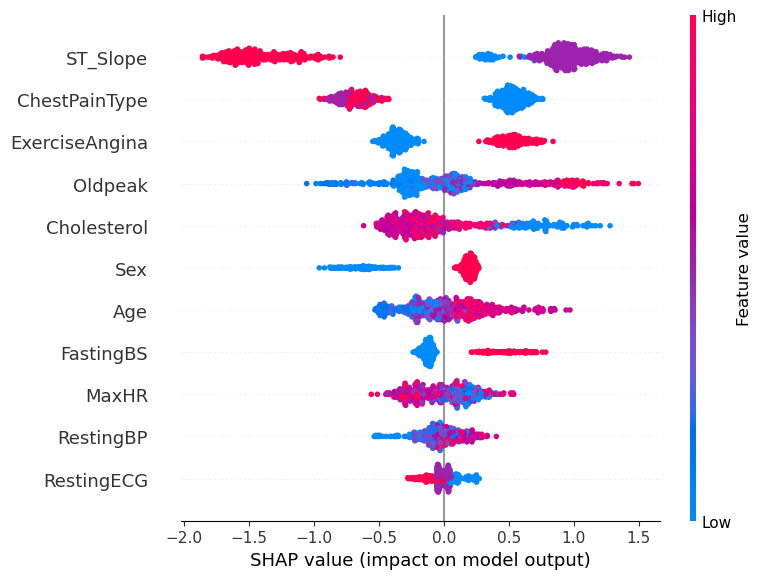

In [158]:
shap.summary_plot(shap_values[1], X_train,show=False)
plt.savefig('shap_lgbm_heart.png')

## Default results

|	|XGBoost|	CatBoost	|LightGBM|
|---|---|---|---|
AUC	|0.84930	|0.90048	|0.86291|
logloss	|5.25595	|3.50396	|4.75538|
KS	|0.69861	|0.80096	|0.72583|
time (s)	|0.13467	|1.41323	|0.06788|

## Optuna results (1h tuning for each model)

|	|XGBoost|	CatBoost	|LightGBM|
|---|---|---|---|
AUC	|0.9555204704	|0.9501851045	|0.9583514808|
logloss	|0.2824692901	|0.3012266495	|0.2908665045|
KS	|0.7900696864	|0.7868031359	|0.8094512195|